# The Cart Pole Environment
Let's take what we've learned and try it out on the [Cart Pole environment](https://gym.openai.com/envs/CartPole-v1/).

In [4]:
import numpy as np
import gym
from util import log_progress
import matplotlib.pyplot as plt
import numpy as np

In [18]:
env = gym.make('CartPole-v1')
observation = env.reset()

[2019-11-21 08:56:29,152] Making new env: CartPole-v1


The idea here is there's a cart you can move left or right, and a pole mounted to a joint.  The agent gets rewards each step the pole is above center.  The episode ends if the cart moves too far to the left or right, or if the pole gets more than 15 degrees from vertical.

Let's bring in some of our earlier code and get a random agent going.

In [1]:
def plot_episode_lengths(episode_lengths):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    plt.show(fig1)

## Neural Net
We're going to need a function approximator. We'll use a neural net for that using the approach desribed in notebook 3, *Neural Net Approximation*.  We will put the function approximator in its own class, because this is a switchable component.  Neural nets are just one way of doing function approximation, and we might want to try some other ways.  It's also nice to keep the function approximation code separate from the Q learning code, to keep the different parts of the code easier to understand.  Plus, keeping them separate makes it easier to test and improve the components  separately from each other.

For example, I think I might want to add dropout and L2 regularization to the neural network later.  Having it as a separate component lets me do that and compare the results of the improved approximator versus the vanilla approximator.

In [2]:
from keras.models import Sequential
from keras.layers import Dense # Dropout, BatchNormalization
from keras.optimizers import Adam

class Approximator:
    """A function approximator implemented with a deep neural net."""
    def __init__(self, num_inputs, num_outputs, learning_rate=0.01):
        self.model = Sequential()
        self.model.add(Dense(32, input_shape=(num_inputs,), activation='relu'))
        #self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(num_outputs, activation='linear'))

        adam = Adam(lr=0.011, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        self.model.compile(optimizer=adam, loss='mse', metrics=['mse'])

    def predict_multi(self, X_batch):
        """Predict the outputs for multiple input values at once.
        X_batch: an np array of m number of X values to predict, of shape (num_inputs, m)
        where m is the number of items you'd like to predict.
        """
        return self.model.predict(X_batch)
    
    def train_multi(self, X, Y, batch_size=16, epochs=1, verbose=0):
        """
        Train the model with m samples.
        X: the input values, of shape (num_inputs, m)
        Y: the target values, of shape (num_outputs, m)
        """
        self.model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    def predict(self, X):
        """Predict a single output given a single input.
        X: one set of X values to predict. X shape is (num_inputs,).
        """
        predictions = self.predict_multi(np.array([X])) # An array for m input values.
        return predictions[0] # We're just doing one here.
    
    def train(self, X, Y):
        """Train a single input/output pair.
        X: inputs of shape (num_inputs,)
        Y: target outputs of shape (num_outputs,)"""
        batch_X = np.array([X])
        batch_Y = np.array([Y])
        self.train_multi(batch_X, batch_Y, batch_size=1)

Using TensorFlow backend.


In [9]:
ap = Approximator(num_inputs=4, num_outputs=2)
X = np.array([[1,2,3,4], [1,1,1,1]])
ap.predict_multi(X)

array([[ 0.18371204,  0.68930346],
       [-0.07629693,  0.23742113]], dtype=float32)

In [10]:
ap.predict(np.array([1,2,3,4]))

array([ 0.18371208,  0.68930358], dtype=float32)

Now we'll train the outputs to be closer to [-4,5]:

In [11]:
ap.train(np.array([1,2,3,4]), np.array([-4, 5]))

In [12]:
ap.predict(np.array([1,2,3,4]))

array([-0.45976734,  1.2333988 ], dtype=float32)

## Agent

In [24]:
class Agent:
    def __init__(self, env, policy):
        self.env = env
        self.policy = policy
    
    def run_episode(self, render=False):
        episode = [] # prev_state, prev_action, reward, state, done
        state = env.reset()
        action = None
        while True:
            prev_state = state
            prev_action = action
            action = self.policy.suggest_action(state)
            state, reward, done, _ = env.step(action)
            episode.append((prev_state, prev_action, reward, state, done))
            self.policy.update_step(prev_state, prev_action, reward, state)
            if render:
                self.env.render()
            if done:
                break
        return episode
    
    def train(self, episodes=100, render=False, epsilon_start=1.0, epsilon_min = 0.01, epsilon_decay=0.99):
        episode_lengths = []
        
        epsilon_orig = agent.policy.epsilon # Save the original epsilon, in case we want to do external things with agent later.
        agent.policy.epsilon = epsilon_start
        
        for i in log_progress(range(episodes), name='Episodes'):
            episode = self.run_episode(render=render)
            episode_lengths.append(len(episode))
            #agent.policy.episode_completed(episode)
            agent.policy.epsilon = max(agent.policy.epsilon * epsilon_decay, epsilon_min) # Decay epsilon, but not below minimum.
            
        plot_episode_lengths(episode_lengths)
        print('Max length=%f avg=%f' % (np.max(episode_lengths), np.mean(episode_lengths)))
        
        agent.policy.epsilon = epsilon_orig # Restore epsilon.

## Deep Q Learning

In [25]:
from collections import deque
import random

class DeepQPolicy:            
    def __init__(self, env, learning_rate=0.001, epsilon=0.1, gamma=0.99, snapshots=1000, batch_size=256):
        """epsilon: probability of exploring by selecting a random action
        gamma: Discount factor for future rewards. Between 0 - 1.
        learning_rate: learning rate for the approximator
        """
        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma # Discount factor for future rewards.
        self.action_list = list(range(self.env.action_space.n)) # All possible actions, like [0,1].
        # Function approximator:
        # Inputs: state
        # Outputs: for each possible action, discounted sum of expected rewards
        num_inputs = env.observation_space.shape[0]
        num_outputs = len(self.action_list)
        self.model = Approximator(num_inputs, num_outputs, learning_rate)
        self.snapshots = deque(maxlen=snapshots)
        self.batch_size = batch_size

    def suggest_action(self, state, epsilon=None):
        if epsilon == None:
            epsilon = self.epsilon
        if np.random.uniform() <= epsilon:
            return self.env.action_space.sample()

        rewards_by_state = self.model.predict(state) # One reward prediction for each possible action.
        action = np.argmax(rewards_by_state) # Index of the best action.
        return action

    def update_step(self, prev_state, prev_action, reward, state):
        """Update the approximations of the reward function.
        See Sutton p. 130 formula 6.7
        """
        prev_rewards_all = self.model.predict(prev_state) # Rewards predicted for prev_state for all actions.
        next_rewards_all = self.model.predict(state) # Rewards for all possible *next* actions.
        
        future_estimate = np.max(next_rewards_all) # Estimated future rewards if we take the best estimated action

        # Update prev_state's estimate to be closer to (the reward we got plus the expected future rewards).
        # target_prev = reward + (gamma * future_estimated)
        q_target = reward + self.gamma * future_estimate
        prev_rewards_all[prev_action] = q_target
        self.model.train(prev_state, prev_rewards_all)

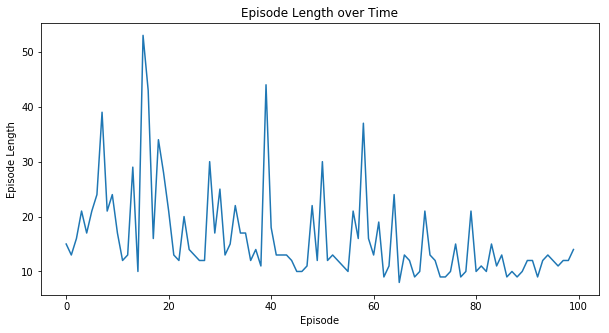

Max length=53.000000 avg=16.160000


In [26]:
agent = Agent(env, DeepQPolicy(env))
agent.train(episodes=100)

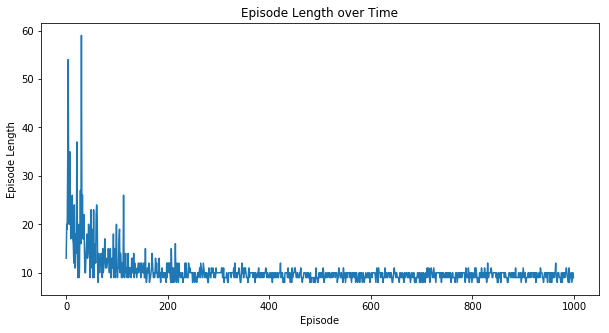

Max length=59.000000 avg=10.340000


In [29]:
agent.train(episodes=1000)

In [30]:
def peek():
    state = env.reset()
    return agent.policy.model.predict(state)
peek()

array([  2.55678259e+10,   9.83604224e+09], dtype=float32)